In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [58]:
import warnings
warnings.filterwarnings('ignore')

In [93]:
df=pd.read_excel("dataIndia.xlsx")
df.Date=pd.to_datetime(df.Date,infer_datetime_format=True)
State_name="all"
df

,Date,State/UnionTerritory,Cured,Deaths,Confirmed
0,2020-01-30,Kerala,0,0,1
1,2020-01-31,Kerala,0,0,1
2,2020-02-01,Kerala,0,0,2
3,2020-02-02,Kerala,0,0,3
4,2020-02-03,Kerala,0,0,3
...,...,...,...,...,...
5856,2020-09-02,Telengana,97402,846,130589
5857,2020-09-02,Tripura,7847,118,12702
5858,2020-09-02,Uttarakhand,14076,280,20398
5859,2020-09-02,Uttar Pradesh,176677,3542,235757


### Creating Data Frame with Confirmed and Cured lags

In [94]:
if State_name=="all":
    df_State=pd.DataFrame((df.groupby('Date')['Deaths','Confirmed','Cured'].sum()))
    df_State.reset_index(inplace = True)
else:
    df_State=df[df['State/UnionTerritory']==State_name]


df_out={'Date': df_State.Date.to_list(),
             'Deaths':df_State.Deaths.to_list(),
            'ConLag5':df_State.Confirmed.shift(5).to_list(),
            'CurLag5':df_State.Cured.shift(5).to_list()
           }

df_out=pd.DataFrame(df_out)
df_out.columns
df_out=df_out.dropna()
df_out.set_index('Date',inplace=True)
for cols in df_out.columns:
    if cols=="Date":
        continue
    else:
        df_out[cols]=df_out[cols].astype(int)

In [95]:
df_State

,Date,Deaths,Confirmed,Cured
0,2020-01-30,0,1,0
1,2020-01-31,0,1,0
2,2020-02-01,0,2,0
3,2020-02-02,0,3,0
4,2020-02-03,0,3,0
...,...,...,...,...
212,2020-08-29,62550,3463972,2648998
213,2020-08-30,63498,3542733,2713933
214,2020-08-31,64469,3621245,2774801
215,2020-09-01,65288,3691166,2839882


In [96]:
df_out

,Deaths,ConLag5,CurLag5
Date,,,
2020-02-04,0,1,0
2020-02-05,0,1,0
2020-02-06,0,2,0
2020-02-07,0,3,0
2020-02-08,0,3,0
...,...,...,...
2020-08-29,62550,3106348,2338035
2020-08-30,63498,3167323,2404585
2020-08-31,64469,3234474,2467758


In [97]:
train=df_out[:]
train


,Deaths,ConLag5,CurLag5
Date,,,
2020-02-04,0,1,0
2020-02-05,0,1,0
2020-02-06,0,2,0
2020-02-07,0,3,0
2020-02-08,0,3,0
...,...,...,...
2020-08-29,62550,3106348,2338035
2020-08-30,63498,3167323,2404585
2020-08-31,64469,3234474,2467758


In [98]:
y_train=train.pop('Deaths')
x_train=train

### Model Building using Linear Regression to select the feature

In [99]:
lm=LinearRegression()


In [100]:
import statsmodels.api as sm  
x_train = sm.add_constant(x_train)
x_train

,const,ConLag5,CurLag5
Date,,,
2020-02-04,1.0,1,0
2020-02-05,1.0,1,0
2020-02-06,1.0,2,0
2020-02-07,1.0,3,0
2020-02-08,1.0,3,0
...,...,...,...
2020-08-29,1.0,3106348,2338035
2020-08-30,1.0,3167323,2404585
2020-08-31,1.0,3234474,2467758


In [101]:
lm = sm.OLS(y_train, x_train).fit()   
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 Deaths   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.222e+04
Date:                Fri, 04 Sep 2020   Prob (F-statistic):          3.57e-244
Time:                        21:35:37   Log-Likelihood:                -1817.8
No. Observations:                 212   AIC:                             3642.
Df Residuals:                     209   BIC:                             3652.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        296.4259    119.356      2.484      0.0

In [102]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,ConLag5,179.59
2,CurLag5,179.59
0,const,1.81


#### We will use ```Confirmed Lag 5``` and ```Cured Lag 5``` as the external regressors to forecast death for the next five days because they have low p-value and low vif score.We can use both of them together or individually. 

### Model Forecasting using Prophet for next five days
    * using confirmed lag 5
    * using cured lag 5

In [103]:
from fbprophet import Prophet

In [116]:
def forecasting(df_out,regressor,table,graph):
    
    df_out1=pd.DataFrame(columns=["ds","y"]) 
    
        
    df_out1['y']=df_out['Deaths']
    df_out1['ds']=df_out.index
    
    if regressor=="Confirmed":
        df_out1['ConLag5']=df_out['ConLag5']
    elif regressor=="Cured":
        df_out1['CurLag5']=df_out['CurLag5']
    else:
        df_out1['ConLag5']=df_out['ConLag5']
        df_out1['CurLag5']=df_out['CurLag5']
        
        
    df_out1.reset_index(inplace=True,drop=True)
    
    #print(df_out1)
    
        
    model=Prophet(daily_seasonality=True,yearly_seasonality=False)
    
    if regressor=="Confirmed":
        model.add_regressor('ConLag5')
    elif regressor=="Cured":
        model.add_regressor('CurLag5')
    else:
        model.add_regressor('ConLag5')
        model.add_regressor('CurLag5')
        
    #print(df_out)    
    model.fit(df_out1)
    
    future = model.make_future_dataframe(periods=5)
    
    if regressor=="Confirmed":
        conlag=list(df_out1['ConLag5'])
        for i in range(5,0,-1):
            conlag.append(list(df_State['Confirmed'])[-i])
        #print(conlag)
            
        future['ConLag5']=list(conlag)
        #print(future)
    elif regressor=="Cured":
        curlag=list(df_out1['CurLag5'])
        #curlag.append(list(df_State['Cured'])[-1])
        for i in range(5,0,-1):
            curlag.append(list(df_State['Cured'])[-i])

        future['CurLag5']=list(curlag)
    else:
        conlag=list(df_out1['ConLag5'])
        for i in range(5,0,-1):
            conlag.append(list(df_State['Confirmed'])[-i])
        #conlag.append(list(df_State['Confirmed'])[-1])
        curlag=list(df_out1['CurLag5'])
        for i in range(5,0,-1):
            curlag.append(list(df_State['Cured'])[-i])
        #curlag.append(list(df_State['Cured'])[-1])
        future['ConLag5']=list(conlag)
        future['CurLag5']=list(curlag)
    #print(future)
    
    forecast=model.predict(future)
    if table=="Yes":
        print("Forecasted Table for number of Deaths for State: "+State_name+"\n")
        Forecast=pd.DataFrame()
        Forecast['Day']=forecast['ds']
        Forecast['Forecasted_Death']=[int(x) for x in list(forecast['yhat'])]
        Forecast['Lower Limit']=[int(x) for x in list(forecast['yhat_lower'])]
        Forecast['Upper Limit']=[int(x) for x in list(forecast['yhat_upper'])]
        Forecast.set_index('Day',inplace=True)
        print(Forecast.tail(5))
    if graph=="Yes":
        print("\nGraphs (Forecasted + Components) for number of Deaths for State: "+State_name)
        model.plot(forecast,xlabel='Date', ylabel='Deaths')
        components_fig=model.plot_components(forecast)
        axes = components_fig.get_axes()
        axes[0].set_ylabel('Trend')
        axes[1].set_ylabel('Weekly')
        axes[2].set_ylabel('Daily')
        axes[3].set_ylabel('Extra_regressors_additive')
        axes[0].set_xlabel('Date')
        axes[1].set_xlabel('Date')
        axes[2].set_xlabel('Date')
        axes[3].set_xlabel('Date')

Forecasted Table for number of Deaths for State: all

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-09-03             67644        67502        67798
2020-09-04             68718        68553        68874
2020-09-05             69791        69626        69954
2020-09-06             70804        70630        70978
2020-09-07             71866        71683        72040

Graphs (Forecasted + Components) for number of Deaths for State: all


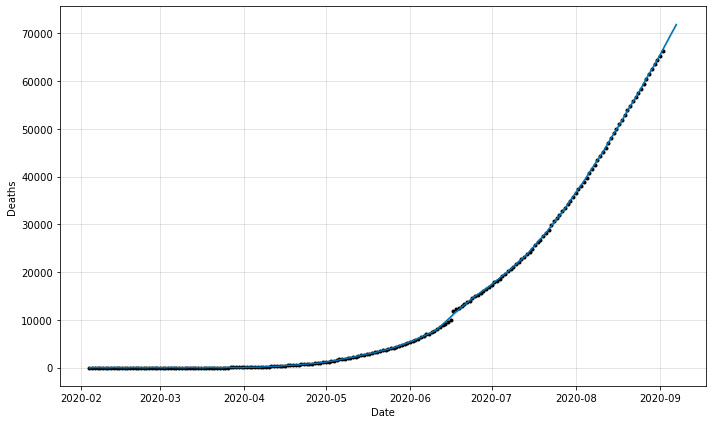

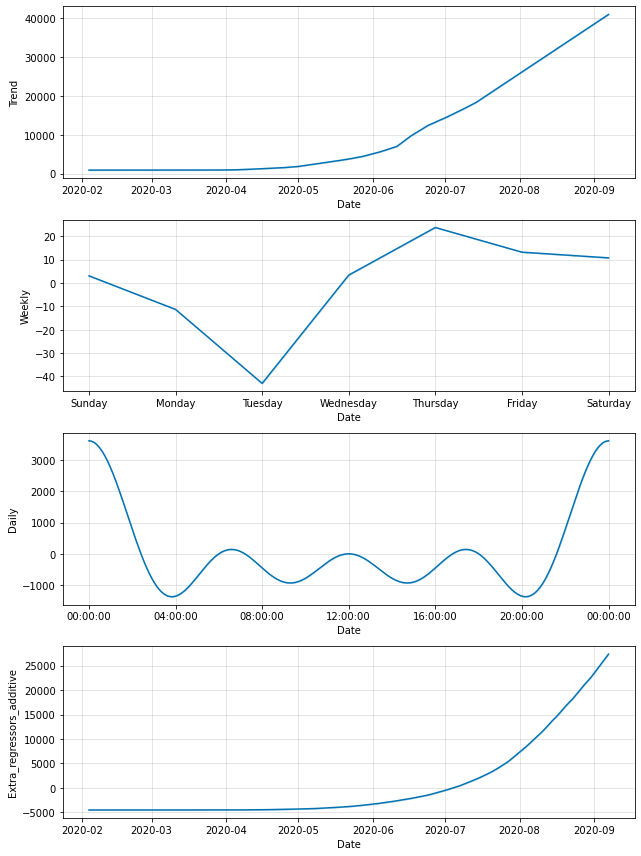

In [117]:
# df=pd.read_csv("prophet_covid.csv")
# #print(df.index)
# df.Date=pd.to_datetime(df.Date,infer_datetime_format=True)

# State_name="Maharashtra"

table="Yes"
graph="Yes"
regressor="Both"
forecasting(df_out,regressor,table,graph)